In [13]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [15]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if any(substring in filename for substring in ["nouns","nounsverbs","nounsverbsadj","functionwords","Original","passageshuffle"]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = []
                if model_identifier in ['distilgpt2','gpt2']:
                    double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                if model_identifier == 'albert-xxlarge-v2':
                    double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
                if model_identifier == 'xlnet-large-cased':
                    double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                final_layer = layers[-1]
                return final_layer
                break

In [16]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            print(filename)
            if any(substring in filename for substring in ["nouns","nounsverbs","nounsverbsadj","functionwords","Original", "passageshuffle"]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = []
                if model_identifier in ['gpt2','distilgpt2']:
                    double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                if model_identifier == 'albert-xxlarge-v2':
                    double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
                if model_identifier == 'xlnet-large-cased':
                    double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
                if model_identifier == 'bert-large-uncased-whole-word-masking':
                    double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                return layers
                break

In [17]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [18]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if any(substring in filename for substring in ["nouns","nounsverbs","nounsverbsadj","functionwords","Original", "passageshuffle"]):
                passage_identifier = get_passage_identifier(filename)
                if not "Original" in filename:
                    condition = filename.split("-")[-3]
                else:
                    condition = filename.split("-")[-2]

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data']
                data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

                if not passage_identifier in model_dictionary:
                    model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary

In [19]:
def get_arrays(dictionary):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    #original,scr1,scr3,scr5,scr7,lowpmi,backward,random = ([] for i in range(8))
    original,nouns,nounsverbs,nounsverbsadj,functionwords,passageshuffle = ([] for i in range(6))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        #print(list(value.keys()))
        original.append(value['Original'].values)
        nouns.append(value['nouns'].values)
        nounsverbs.append(value['nounsverbs'].values)
        nounsverbsadj.append(value['nounsverbsadj'].values)
        functionwords.append(value['functionwords'].values)
        passageshuffle.append(value['passageshuffle'].values)
        
    #print(np.shape(original))
    return original,nouns,nounsverbs,nounsverbsadj,functionwords,passageshuffle #backward,random

In [20]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [21]:
#def prepare_dataframe(original,scr1,scr3,scr5,scr7,lowpmi,backward,random,flatten=True):
def prepare_dataframe(original,nouns,nounsverbs,nounsverbsadj,functionwords,passageshuffle,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'Original':np.asarray(flatten_array(original)).flatten(),
                             'nouns':np.asarray(flatten_array(nouns)).flatten(),
                              'nounsverbs':np.asarray(flatten_array(nounsverbs)).flatten(),
                              'nounsverbsadj':np.asarray(flatten_array(nounsverbsadj)).flatten(),
                              'functionwords':np.asarray(flatten_array(functionwords)).flatten(),
                               'passageshuffle': np.asarray(flatten_array(passageshuffle)).flatten()})
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'Original':flatten_array(original),
                             'nouns':flatten_array(nouns),
                              'nounsverbs':flatten_array(nounsverbs),
                              'nounsverbsadj':flatten_array(nounsverbsadj),
                              'functionwords':flatten_array(functionwords),
                              'passageshuffle':flatten_array(passageshuffle)}
    return df

In [22]:
def main_df_for_plotting(model_identifier, layer_identifier=None, flatten=True):
    model_dict = get_dictionary(model_identifier, layer_identifier)
    df = prepare_dataframe(*get_arrays(model_dict), flatten=flatten) #*flattens the tuple
    return df

In [23]:
def get_activation_dfs_for_all_layers(model_identifier, flatten=True):
    """
    input: model_identifier, whether to flatten (i.e. all sentence reps in one vector or leave 627*hidden size)
    output: dictionary: layer --> dataframe (conditions as column names, column values are flattened or unflattened activations)
    """
    layers = get_all_layers(model_identifier)
    print(layers)
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,layer_identifier=elm,flatten=flatten)
    return df_dict

In [24]:
distilgpt2_correlation_dict = get_activation_dfs_for_all_layers("distilgpt2")

 29%|██▊       | 4210/14724 [00:00<00:00, 40145.46it/s]

identifier=distilgpt2,stimuli_identifier=Pereira2018-Original-243sentences1.pkl
['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop


 29%|██▊       | 4210/14724 [00:00<00:00, 40798.74it/s]

This is the layer I'm looking at:  encoder.h.0


 29%|██▊       | 4210/14724 [00:00<00:00, 38962.46it/s]

This is the layer I'm looking at:  encoder.h.1


 29%|██▊       | 4211/14724 [00:00<00:00, 37626.81it/s]

This is the layer I'm looking at:  encoder.h.2


 29%|██▊       | 4210/14724 [00:00<00:00, 40708.26it/s]

This is the layer I'm looking at:  encoder.h.3


 29%|██▊       | 4211/14724 [00:00<00:00, 38383.93it/s]

This is the layer I'm looking at:  encoder.h.4


 29%|██▊       | 4210/14724 [00:00<00:00, 38493.78it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 14724/14724 [00:11<00:00, 1302.98it/s]


In [25]:
print(distilgpt2_correlation_dict.keys())

dict_keys(['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5'])


In [26]:
print(distilgpt2_correlation_dict['drop'].shape)

(481536, 6)


In [27]:
orig_column = distilgpt2_correlation_dict['drop']['Original']
conditions = list(distilgpt2_correlation_dict['drop'].columns)

for elm in conditions:
    correlation = orig_column.corr(distilgpt2_correlation_dict['drop'][elm])
    print(elm, correlation)

print("\n")
correlations = [orig_column.corr(distilgpt2_correlation_dict['drop'][elm]) for elm in conditions]
print(correlations)

Original 0.9999999999999999
nouns 0.838284876029786
nounsverbs 0.9053629106455982
nounsverbsadj 0.9449278240221978
functionwords 0.5464528023507941
passageshuffle 0.5820257642722818


[0.9999999999999999, 0.838284876029786, 0.9053629106455982, 0.9449278240221978, 0.5464528023507941, 0.5820257642722818]


identifier=distilgpt2,stimuli_identifier=Pereira2018-Original-243sentences1.pkl


([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

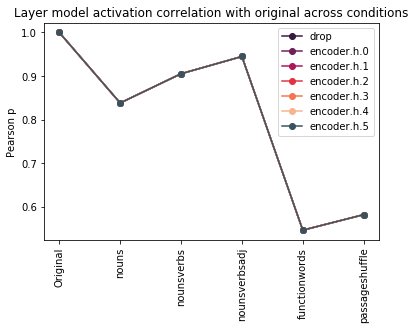

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
layers = get_all_layers("distilgpt2")
line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d")
    
x = conditions
counter = 0
for key,value in distilgpt2_correlation_dict.items():
    ax.plot(x,correlations, '-o',color=line_colors[counter])
    counter += 1

    #conditions = list(distilgpt2_score_dict.keys())

ax.set_title('Layer model activation correlation with original across conditions')
ax.legend(layers)
ax.yaxis.set_label_text('Pearson p')
plt.xticks(rotation= 90)

In [29]:
def get_correlations_df_dict(model_identifier): #maybe pass activations dict as input so it doesn't have to recompute
    layers = get_all_layers(model_identifier)
    activations_dict = get_activation_dfs_for_all_layers(model_identifier)
    
    conditions = list(activations_dict[layers[0]].columns)
    
    correlations_df_dict = {}
    for layer in layers:
        orig_column = activations_dict[layer]['Original']
        correlations = [orig_column.corr(activations_dict[layer][elm]) for elm in conditions]
        correlations_df_dict[layer] = correlations
    
    return layers, conditions, correlations_df_dict

In [30]:
layers, conditions, distilgpt2_corr_dict = get_correlations_df_dict("distilgpt2")

 29%|██▊       | 4210/14724 [00:00<00:00, 39316.49it/s]

identifier=distilgpt2,stimuli_identifier=Pereira2018-Original-243sentences1.pkl
identifier=distilgpt2,stimuli_identifier=Pereira2018-Original-243sentences1.pkl
['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop


 29%|██▊       | 4210/14724 [00:00<00:00, 39909.46it/s]

This is the layer I'm looking at:  encoder.h.0


 29%|██▊       | 4210/14724 [00:00<00:00, 40848.38it/s]

This is the layer I'm looking at:  encoder.h.1


 29%|██▊       | 4210/14724 [00:00<00:00, 40180.54it/s]

This is the layer I'm looking at:  encoder.h.2


 29%|██▊       | 4211/14724 [00:00<00:00, 38850.84it/s]

This is the layer I'm looking at:  encoder.h.3


 29%|██▊       | 4209/14724 [00:00<00:00, 37986.46it/s]

This is the layer I'm looking at:  encoder.h.4


 29%|██▊       | 4210/14724 [00:00<00:00, 41315.94it/s]

This is the layer I'm looking at:  encoder.h.5


100%|██████████| 14724/14724 [00:10<00:00, 1382.75it/s]


In [38]:
def plot_correlations_lineplot(model_identifier, layers, conditions, correlations_dict):
    fig, ax = plt.subplots()
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
        line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    layers = layers
    conditions = conditions
    
    counter = 0
    for key,value in correlations_dict.items():
        ax.plot(conditions,value, '-o',color=line_colors[counter])
        counter += 1

    ax.set_title('Layer model activation correlation with model activations for original sentence across conditions')
    if not model_identifier in ['xlnet-large-cased', 'albert-xxlarge-v2', 'bert-large-uncased-whole-word-masking']:
        ax.legend(layers)
    else:
        ax.legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.yaxis.set_label_text('Pearson p')
    plt.xticks(rotation= 90)
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    savename = 'fig/model-activation-correlation-{}.png'.format(model_identifier)
    plt.savefig(savename, bbox_inches='tight', dpi=240)

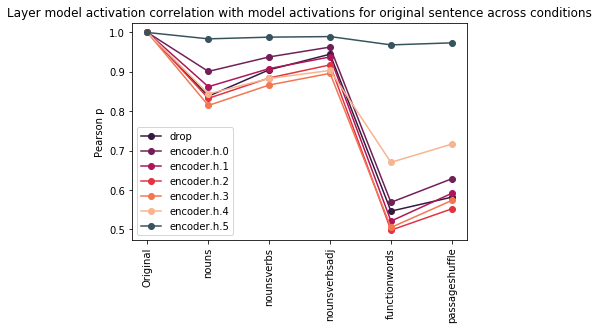

In [39]:
plot_correlations_lineplot("distilgpt2", layers, conditions, distilgpt2_corr_dict)

In [33]:
distilgpt2_avg_layers, distilgpt2_avg_conditions, distilgpt2_avg_corr_dict = get_correlations_df_dict("distilgpt2-avgtoken")
plot_correlations_lineplot("distilgpt2-avgtoken", distilgpt2_avg_layers, distilgpt2_avg_conditions, distilgpt2_avg_corr_dict)

 43%|████▎     | 6393/14724 [00:00<00:00, 61159.84it/s]

identifier=distilgpt2-avgtoken,stimuli_identifier=Pereira2018-functionwords-avgtoken-243sentences1.pkl
identifier=distilgpt2-avgtoken,stimuli_identifier=Pereira2018-functionwords-avgtoken-243sentences1.pkl
['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5']
This is the layer I'm looking at:  drop


100%|██████████| 14724/14724 [00:11<00:00, 1292.30it/s]


KeyError: 'Original'

In [116]:
import math
from matplotlib.gridspec import GridSpec

def get_corr_lineplots_loop(model_list):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    #line_colors = sns.color_palette("rocket") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]] + sns.color_palette("GnBu_d")
    #line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
    #if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
    #    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 5*nrows))
    fig2.suptitle('Layer model activation correlation with model activations for unscrambled sentence across conditions', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                model_identifier = model_list[model_counter]
                line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + [sns.color_palette("PRGn", 10)[2]] + [sns.color_palette("PuOr", 10)[0]]
                if model_identifier in ['xlnet-large-cased','bert-large-uncased-whole-word-masking']:
                    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
                layers, conditions, correlations_df_dict = get_correlations_df_dict(model_identifier)
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                
                counter = 0
                for key,value in correlations_df_dict.items():
                    f2_ax[-1].plot(conditions,value, '-o',color=line_colors[counter])
                    counter += 1
                f2_ax[-1].set_title('{}'.format(model_identifier),fontsize=18)
                f2_ax[-1].yaxis.set_label_text('Pearson p')
                #shorten names for legend
                if model_identifier == 'lm_1b':
                    layers = [layer.split('/')[1] for layer in layers]
                if 'albert' in model_identifier:
                    layers = [re.sub('.albert_layer_groups.','.h.', layer) for layer in layers]
                if model_identifier == 'bert-large-uncased-whole-word-masking':
                    layers = ['.'.join(layer.split('.')[:-1]) if '.' in layer else layer for layer in layers]
                f2_ax[-1].legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.xticks(rotation= 90)
                model_counter += 1
    fig2.savefig('fig/final-activations-layer-comparison.png', bbox_inches='tight')

In [117]:
#get_corr_lineplots_loop(['glove','lm_1b','skip-thoughts', 'albert-xxlarge-v2','bert-large-uncased-whole-word-masking', 'xlnet-large-cased', 'distilgpt2', 'gpt2']) #'distilbert-base-uncased'